# Spike Gadgets Ephys and Video Syncing

In [1]:
import os
import re
import sys
from collections import defaultdict
import random
from random import randrange
import glob
import warnings

In [2]:
import numpy as np
import pandas as pd
# import cv2
from IPython.display import Video
import matplotlib.pyplot as plt

In [3]:
# setting path
sys.path.append('../../../../src/')

In [4]:
import trodes.read_exported

In [5]:
%matplotlib inline

In [6]:
import spikeinterface

In [7]:
import spikeinterface as si  # import core only
import spikeinterface.extractors as se
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw

In [8]:
import spikeinterface.core

In [9]:
from probeinterface import get_probe
from probeinterface.plotting import plot_probe, plot_probe_group
from probeinterface import write_prb, read_prb

In [10]:
import spikeinterface.full as si

# Part 0: Index of all the column names

raw directory
- raw_group0.dat
    - voltage_value: Array with voltage measurement for each channel at each timestamp
- timestamps.dat
    - voltage_time_stamp: The time stamp of each voltage measurement

parent directory
- 1.videoTimeStamps.cameraHWSync
    - frame_number: Calculated by getting the index of each video time stamp tuple 
    - PosTimestamp: The time stamp of each video frame
    - HWframeCount: Unknown value. Starts at 30742 and increases by 1 for each tuple  
    - HWTimestamp: Unknown value. All zeroes
    - video_time: Calculated by dividing the frame number by the fps(frames per second) 
    - video_seconds: video_time, but rounded to seconds  	
    - These are filled in versions of the above collumns with the value from the most recent previous cell
        - filled_PosTimestamp 	
        - filledHWframeCount 	
        - filled_frame_number 	
        - filled_video_time 	
        - filled_video_seconds 	

DIO directory
- dio_ECU_Din1.dat
    - time: The time stamp the corresponds to the DIN input
    - state: Binary state of whether there is input from DIN or not 	
    - trial_number: Calculated by adding 1 to every time there is a DIN input
    - These are filled in versions of the above collumns with the value from the most recent previous cell
        - filled_state 	
        - filled_trial_number

ss_output directory (Spike sorting with Spike interface)
- firings.npz
    - unit_id: All the units that had a spike train for the given timestamp 	
    - number_of_units: Calculated by counting the number of units that had a spike train

# Part 1: Inputting Data

## Name of protocol for naming

- This name will be used to name files and title plots. Please change if you are using a different protocol or adding more details
    - **NOTE**: This should be changed based on the name the protocol

In [11]:
protocol_name = "rc_om_and_comp"

## Getting the file name of the raw data

- Default input folder and keyword to search the files for 
    - **NOTE**: This should not be changed unless there is a consistent change with the file naming convention

In [12]:
input_folder = "./data"

- Make this cell into non-code block if you are using the same file path for multiple runs

In [13]:
import git

In [14]:
git_repo = git.Repo(".", search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")

In [15]:
git_root

'/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls'

In [16]:
recording_filepath_glob = "data/good/20221214_125409_om_and_comp_6_1_and_6_3.rec/subj_6_1"

In [17]:
recording_absolultepath_glob = os.path.join(git_root, recording_filepath_glob)

In [18]:
git_root

'/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls'

In [19]:
recording_filepath_glob

'data/good/20221214_125409_om_and_comp_6_1_and_6_3.rec/subj_6_1'

In [20]:
recording_absolultepath_glob

'/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/data/good/20221214_125409_om_and_comp_6_1_and_6_3.rec/subj_6_1'

In [21]:
# Getting all the file paths of the recording files(that happen to all end in `.rec`)
raw_data_all_files = glob.glob(recording_absolultepath_glob, recursive=True)

In [22]:
raw_data_all_files

['/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/data/good/20221214_125409_om_and_comp_6_1_and_6_3.rec/subj_6_1']

In [23]:
raw_data_file_path = raw_data_all_files[0]

## Extracting the data and the metadata from the Recording folder

- Creating a dictionary that has the directory as the key and a dictionary that has the file name as the key and the 

In [24]:
file_to_data = trodes.read_exported.get_all_trodes_data_from_directory(raw_data_file_path)

/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2023_05_17_lfp_analysis/proc/20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3/../../../../src/trodes/read_exported.py:70: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)


file prefix: group0.coordinates.dat
directory prefix: raw
file prefix: raw_group0.dat
directory prefix: raw
file prefix: timestamps.dat
directory prefix: raw
file prefix: group0.coordinates.dat
directory prefix: kilosort
file prefix: timestamps.dat
directory prefix: kilosort
file prefix: group0.coordinates.dat
directory prefix: mountainsort
file prefix: spikes_nt28.dat
directory prefix: spikes
file prefix: spikes_nt10.dat
directory prefix: spikes
file prefix: spikes_nt22.dat
directory prefix: spikes
file prefix: spikes_nt6.dat
directory prefix: spikes
file prefix: spikes_nt3.dat
directory prefix: spikes
file prefix: spikes_nt27.dat
directory prefix: spikes
file prefix: spikes_nt23.dat
directory prefix: spikes
file prefix: spikes_nt30.dat
directory prefix: spikes
file prefix: spikes_nt26.dat
directory prefix: spikes
file prefix: spikes_nt25.dat
directory prefix: spikes
file prefix: spikes_nt7.dat
directory prefix: spikes
file prefix: spikes_nt31.dat
directory prefix: spikes
file prefix:

/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2023_05_17_lfp_analysis/proc/20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3/../../../../src/trodes/read_exported.py:138: UserWarning: Can not process /nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/data/good/20221214_125409_om_and_comp_6_1_and_6_3.rec/subj_6_1/20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3.kilosort/20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3.group0.dat
  warnings.warn("Can not process {}".format(absolute_file_path))
/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2023_05_17_lfp_analysis/proc/20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3/../../../../src/trodes/read_exported.py:138: UserWarning: Can not process /nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/data/good/20221214_125409_om_and_comp_6_1_and_6_3.rec/subj_6_1/20221214_125409_om_

file prefix: spikes_nt11.dat
directory prefix: spikes
file prefix: spikes_nt32.dat
directory prefix: spikes
file prefix: spikes_nt9.dat
directory prefix: spikes
file prefix: analog_ECU_Aout1.dat
directory prefix: analog
file prefix: analog_ECU_Ain1.dat
directory prefix: analog
file prefix: analog_ECU_Aout4.dat
directory prefix: analog
file prefix: analog_ECU_Aout2.dat
directory prefix: analog
file prefix: analog_ECU_Aout3.dat
directory prefix: analog
file prefix: analog_Headstage_MagZ.dat
directory prefix: analog
file prefix: analog_Headstage_GyroX.dat
directory prefix: analog
file prefix: analog_Headstage_AccelZ.dat
directory prefix: analog
file prefix: analog_Headstage_MagX.dat
directory prefix: analog
file prefix: analog_ECU_Ain8.dat
directory prefix: analog
file prefix: analog_ECU_Ain6.dat
directory prefix: analog
file prefix: analog_Headstage_AccelX.dat
directory prefix: analog
file prefix: analog_ECU_Ain3.dat
directory prefix: analog
file prefix: analog_Headstage_GyroZ.dat
direct

/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2023_05_17_lfp_analysis/proc/20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3/../../../../src/trodes/read_exported.py:138: UserWarning: Can not process /nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/data/good/20221214_125409_om_and_comp_6_1_and_6_3.rec/subj_6_1/20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3.timestampoffset/20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3.timestampoffset.txt
  warnings.warn("Can not process {}".format(absolute_file_path))


- All the folders that were extracted from

In [25]:
file_to_data.keys()

dict_keys(['20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3.raw', 'raw', '20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3.kilosort', 'kilosort', '20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3.mountainsort', 'mountainsort', '20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3.spikes', 'spikes', '.', '20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3.analog', 'analog', '20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3.stimulation', 'stimulation', '20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3.spikeband', 'spikeband', '20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3.timestampoffset', '20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3.LFP', 'LFP', '20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3.DIO', 'DIO'])

- Looking over all the extracted data

In [26]:
for key, value in file_to_data.items():
    print("Directory: {}".format(key))
    for file_name, trodes_dict in value.items():
        print("\tFile Name: {}".format(file_name))
        for data_type, data_value in trodes_dict.items():
            print("\n \t \t Trodes Data Type: {}".format(data_type))
            print("\t \t Python Type: {}".format(type(data_value)))
            print("\t \t Data Value: {}".format(data_value))

Directory: 20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3.raw
	File Name: group0.coordinates.dat

 	 	 Trodes Data Type: description
	 	 Python Type: <class 'str'>
	 	 Data Value: Pad locations in microns

 	 	 Trodes Data Type: byte_order
	 	 Python Type: <class 'str'>
	 	 Data Value: little endian

 	 	 Trodes Data Type: original_file
	 	 Python Type: <class 'str'>
	 	 Data Value: 20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3.rec

 	 	 Trodes Data Type: clockrate
	 	 Python Type: <class 'str'>
	 	 Data Value: 20000

 	 	 Trodes Data Type: trodes_version
	 	 Python Type: <class 'str'>
	 	 Data Value: 2.3.2

 	 	 Trodes Data Type: compile_date
	 	 Python Type: <class 'str'>
	 	 Data Value: Apr 12 2022

 	 	 Trodes Data Type: compile_time
	 	 Python Type: <class 'str'>
	 	 Data Value: 15:21:02

 	 	 Trodes Data Type: qt_version
	 	 Python Type: <class 'str'>
	 	 Data Value: 6.2.2

 	 	 Trodes Data Type: commit_tag
	 	 Python Type: <class 'str'>
	 	 Data Value: heads/Release_2

# Part 2: Looking over the data

## Looking over the MED-PC Data

- Box 1 Port Entries
    - ECU Din3
- Box 2 Port Entries
    - Controller Din1
- Box 1 Tone playing
    - ECU Din1

In [27]:
DIO_directory_name = trodes.read_exported.get_key_with_substring(file_to_data, substring="DIO")

In [28]:
DIO_directory_name

'DIO'

In [29]:
DIO_directory_dict = file_to_data[DIO_directory_name]

In [30]:
DIO_directory_dict.keys()

dict_keys(['dio_ECU_Din2.dat', 'dio_ECU_Dout6.dat', 'dio_ECU_Din25.dat', 'dio_ECU_Din11.dat', 'dio_ECU_Din21.dat', 'dio_ECU_Dout27.dat', 'dio_Controller_Din6.dat', 'dio_Controller_Din8.dat', 'dio_ECU_Dout8.dat', 'dio_ECU_Din9.dat', 'dio_ECU_Din13.dat', 'dio_ECU_Din12.dat', 'dio_ECU_Dout18.dat', 'dio_ECU_Din29.dat', 'dio_ECU_Din3.dat', 'dio_ECU_Dout25.dat', 'dio_ECU_Dout31.dat', 'dio_ECU_Dout1.dat', 'dio_ECU_Dout32.dat', 'dio_ECU_Din24.dat', 'dio_ECU_Din26.dat', 'dio_ECU_Dout3.dat', 'dio_ECU_Dout20.dat', 'dio_ECU_Din16.dat', 'dio_ECU_Dout10.dat', 'dio_ECU_Dout21.dat', 'dio_ECU_Din22.dat', 'dio_ECU_Din23.dat', 'dio_ECU_Din18.dat', 'dio_ECU_Din31.dat', 'dio_ECU_Dout17.dat', 'dio_ECU_Din20.dat', 'dio_Controller_Din1.dat', 'dio_ECU_Dout7.dat', 'dio_ECU_Din30.dat', 'dio_Controller_Din2.dat', 'dio_ECU_Dout12.dat', 'dio_Controller_Din5.dat', 'dio_ECU_Din7.dat', 'dio_ECU_Dout30.dat', 'dio_ECU_Dout9.dat', 'dio_ECU_Dout4.dat', 'dio_ECU_Din19.dat', 'dio_ECU_Din14.dat', 'dio_ECU_Din6.dat', 'dio_ECU

### Tone Onset Signal

In [31]:
tone_onset_DIN_file_name = trodes.read_exported.get_key_with_substring(DIO_directory_dict, substring="ECU_Din1.dat", return_first=True)

In [32]:
tone_onset_DIN_file_name

'dio_ECU_Din1.dat'

In [33]:
tone_onset_DIN_state_array = DIO_directory_dict[tone_onset_DIN_file_name]["data"]

In [34]:
tone_onset_DIN_state_array

array([( 2951903, 1), ( 3159550, 0), ( 4359951, 1), ( 4559950, 0),
       ( 5959954, 1), ( 6159948, 0), ( 7759946, 1), ( 7959946, 0),
       ( 9359945, 1), ( 9559944, 0), (10859943, 1), (11059942, 0),
       (12859940, 1), (13059938, 0), (14759938, 1), (14959938, 0),
       (16559934, 1), (16759938, 0), (18159935, 1), (18359934, 0),
       (19959932, 1), (20159930, 0), (21959930, 1), (22159930, 0),
       (23759929, 1), (23959928, 0), (26159926, 1), (26359925, 0),
       (27959924, 1), (28159923, 0), (28359523, 1), (29750102, 0),
       (30950500, 1), (31150501, 0), (32550496, 1), (32750498, 0),
       (34350494, 1), (34550497, 0), (35950496, 1), (36150495, 0),
       (37450494, 1), (37650493, 0), (39450491, 1), (39650491, 0),
       (41350489, 1), (41550489, 0), (43150487, 1), (43350488, 0),
       (44750483, 1), (44950483, 0), (46550484, 1), (46750484, 0),
       (48550482, 1), (48750479, 0), (50350480, 1), (50550479, 0),
       (52750475, 1), (52950477, 0), (54550473, 1), (54750475,

(array([35.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 36.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

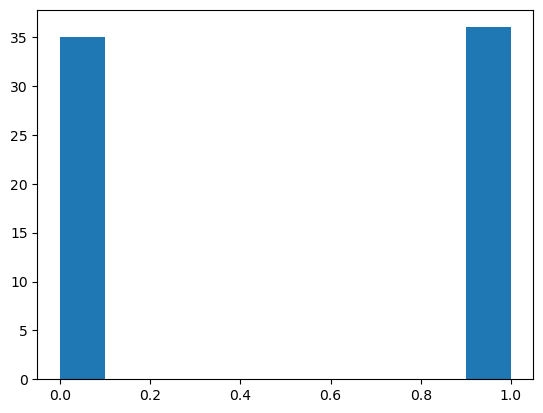

In [35]:
plt.hist([tup[1] for tup in tone_onset_DIN_state_array])

Text(0.5, 1.0, 'Din State Change against Timestamps')

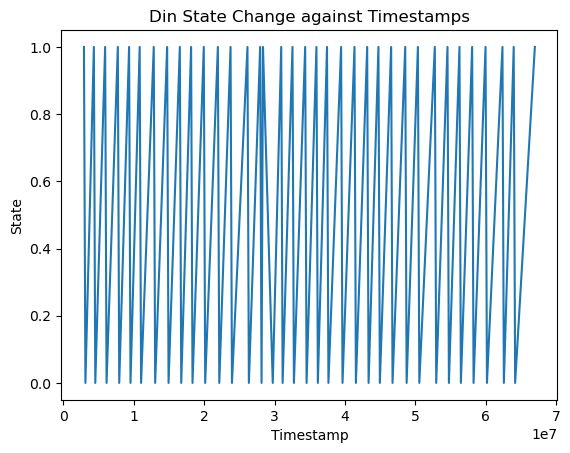

In [36]:
plt.plot([tup[0] for tup in tone_onset_DIN_state_array], [tup[1] for tup in tone_onset_DIN_state_array])
plt.xlabel("Timestamp")
plt.ylabel("State")
plt.title("Din State Change against Timestamps")

### Box 1 Port Entries

In [37]:
box1_port_entries_DIN_file_name = trodes.read_exported.get_key_with_substring(DIO_directory_dict, substring="ECU_Din3.dat", return_first=True)

In [38]:
box1_port_entries_DIN_file_name

'dio_ECU_Din3.dat'

In [39]:
box1_port_entries_DIN_state_array = DIO_directory_dict[box1_port_entries_DIN_file_name]["data"]

In [40]:
box1_port_entries_DIN_state_array

array([( 2951903, 1), ( 3159550, 0), ( 4064951, 1), ..., (66884062, 1),
       (66900862, 0), (66950060, 1)],
      dtype=[('time', '<u4'), ('state', 'u1')])

(array([1399.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1400.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

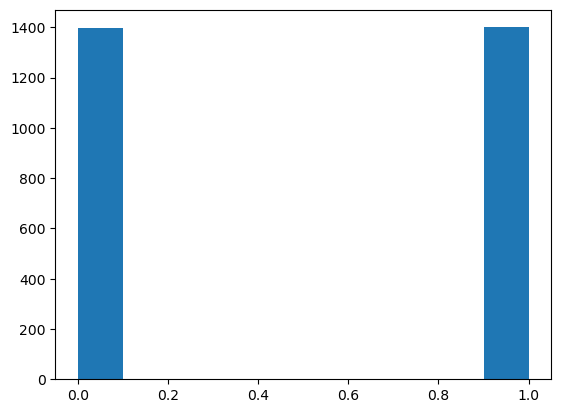

In [41]:
plt.hist([tup[1] for tup in box1_port_entries_DIN_state_array])

- There is a gap in the middle when the protocol was being changed between competition or omission

Text(0.5, 1.0, 'Din State Change against Timestamps')

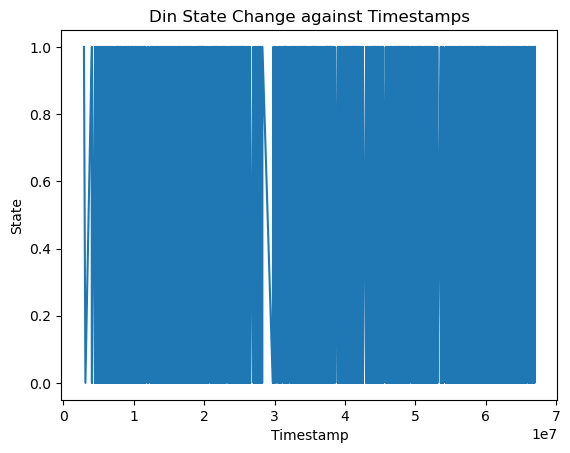

In [42]:
plt.plot([tup[0] for tup in box1_port_entries_DIN_state_array], [tup[1] for tup in box1_port_entries_DIN_state_array])
plt.xlabel("Timestamp")
plt.ylabel("State")
plt.title("Din State Change against Timestamps")

### Box 2 Port Entries

In [43]:
box2_port_entries_DIN_file_name = trodes.read_exported.get_key_with_substring(DIO_directory_dict, substring="dio_Controller_Din1.dat", return_first=True)

In [44]:
box2_port_entries_DIN_file_name

'dio_Controller_Din1.dat'

In [45]:
box2_port_entries_DIN_file_name = DIO_directory_dict[box2_port_entries_DIN_file_name]["data"]

In [46]:
box2_port_entries_DIN_file_name

array([( 2951903, 1), ( 3159548, 0), ( 4484546, 1), ( 4512348, 0),
       ( 4513746, 1), ( 4515548, 0), ( 4516748, 1), ( 4541148, 0),
       ( 4541548, 1), ( 4543948, 0), ( 4944948, 1), ( 4964948, 0),
       ( 4965545, 1), ( 4976148, 0), ( 5109345, 1), ( 5110350, 0),
       ( 5110945, 1), ( 5127545, 0), ( 5183947, 1), ( 5202147, 0),
       ( 5420747, 1), ( 5505945, 0), ( 5921547, 1), ( 5952949, 0),
       ( 5996946, 1), ( 5998546, 0), ( 6001546, 1), ( 6008544, 0),
       ( 6012546, 1), ( 6013546, 0), ( 6014349, 1), ( 6026946, 0),
       ( 6032746, 1), ( 6033746, 0), ( 6035344, 1), ( 6274746, 0),
       ( 6454746, 1), ( 6491546, 0), ( 6687346, 1), ( 6714343, 0),
       ( 6747343, 1), ( 6749146, 0), ( 6749546, 1), ( 6753146, 0),
       ( 7020545, 1), ( 7042745, 0), ( 7146745, 1), ( 7178145, 0),
       ( 7482945, 1), ( 7511142, 0), ( 7720144, 1), ( 7745542, 0),
       ( 7760944, 1), ( 7762744, 0), ( 7766744, 1), ( 7775544, 0),
       ( 7782144, 1), ( 7796144, 0), ( 7801944, 1), ( 7802944,

(array([485.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 486.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

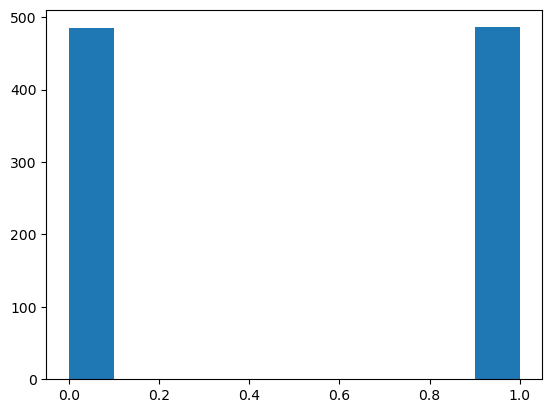

In [47]:
plt.hist([tup[1] for tup in box2_port_entries_DIN_file_name])

- This is half the time than the previous port entries, because the mouse was moved to box 1 for half of the session

Text(0.5, 1.0, 'Din State Change against Timestamps')

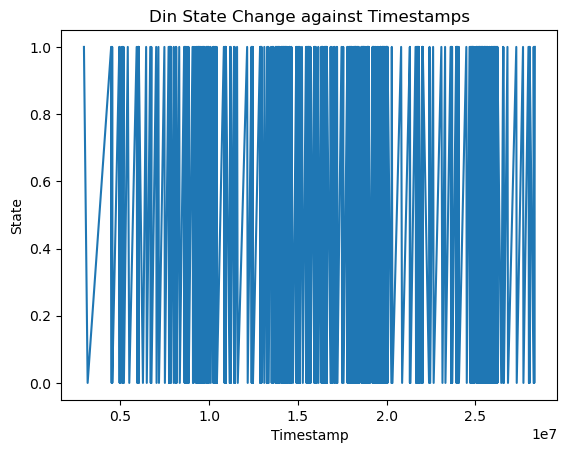

In [48]:
plt.plot([tup[0] for tup in box2_port_entries_DIN_file_name], [tup[1] for tup in box2_port_entries_DIN_file_name])
plt.xlabel("Timestamp")
plt.ylabel("State")
plt.title("Din State Change against Timestamps")

## Labeling the Tone and Port Entries

# Syncing with MED-PC

- List of when the ECU has changed signal. 1 means that the ECU Din1 signal is on, 0 means it's off.

In [49]:
tone_onset_DIN_state_array

array([( 2951903, 1), ( 3159550, 0), ( 4359951, 1), ( 4559950, 0),
       ( 5959954, 1), ( 6159948, 0), ( 7759946, 1), ( 7959946, 0),
       ( 9359945, 1), ( 9559944, 0), (10859943, 1), (11059942, 0),
       (12859940, 1), (13059938, 0), (14759938, 1), (14959938, 0),
       (16559934, 1), (16759938, 0), (18159935, 1), (18359934, 0),
       (19959932, 1), (20159930, 0), (21959930, 1), (22159930, 0),
       (23759929, 1), (23959928, 0), (26159926, 1), (26359925, 0),
       (27959924, 1), (28159923, 0), (28359523, 1), (29750102, 0),
       (30950500, 1), (31150501, 0), (32550496, 1), (32750498, 0),
       (34350494, 1), (34550497, 0), (35950496, 1), (36150495, 0),
       (37450494, 1), (37650493, 0), (39450491, 1), (39650491, 0),
       (41350489, 1), (41550489, 0), (43150487, 1), (43350488, 0),
       (44750483, 1), (44950483, 0), (46550484, 1), (46750484, 0),
       (48550482, 1), (48750479, 0), (50350480, 1), (50550479, 0),
       (52750475, 1), (52950477, 0), (54550473, 1), (54750475,

- Checking to see if 1 or 0 is when the tone plays
    - Dividing by 20000, because we are recording at a sampling rate at 20000

In [50]:
tone_onset_DIN_state_array[0][0]

2951903

In [51]:
tone_onset_DIN_state_array[1][0]

3159550

In [52]:
tone_onset_DIN_state_array[2][0]

4359951

- So the tone starts when the state is "1"
    - This can be seen because the time from 1 to 0 is 10 seconds

In [53]:
(tone_onset_DIN_state_array[1][0] - tone_onset_DIN_state_array[0][0]) / 20000

10.38235

- So the tone starts when the state is "2"
    - This can be seen because the time from 0 to 1 is 60 seconds, the time for one session

In [54]:
(tone_onset_DIN_state_array[2][0] - tone_onset_DIN_state_array[1][0]) / 20000

60.02005

- Getting only the times when the ECU signal was on

In [55]:
tone_din_time = [din_time for din_time, din_state in tone_onset_DIN_state_array if din_state == 1]

In [56]:
len(tone_din_time)

36

In [57]:
tone_din_time[:10]

[2951903,
 4359951,
 5959954,
 7759946,
 9359945,
 10859943,
 12859940,
 14759938,
 16559934,
 18159935]

## Looking over the ephys recording

- Getting the name of the ephys recording direcotry

In [58]:
raw_directory_dict = file_to_data["raw"]

- Getting the name of the files in the ephys recording directory

In [59]:
raw_directory_dict.keys()

dict_keys(['group0.coordinates.dat', 'raw_group0.dat', 'timestamps.dat'])

In [60]:
raw_recording_fields_text = raw_directory_dict["raw_group0.dat"]

In [61]:
raw_recording_fields_text

{'description': 'Raw (unfiltered) data for one sorting group',
 'byte_order': 'little endian',
 'original_file': '20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3.rec',
 'clockrate': '20000',
 'trodes_version': '2.3.2',
 'compile_date': 'Apr 12 2022',
 'compile_time': '15:21:02',
 'qt_version': '6.2.2',
 'commit_tag': 'heads/Release_2.3.2-0-g15f12712',
 'controller_firmware': '3.17',
 'headstage_firmware': '2.2',
 'controller_serialnum': '00104 00176',
 'headstage_serialnum': '01601 00129',
 'autosettle': '0',
 'smartref': '0',
 'gyro': '0',
 'accelerometer': '0',
 'magnetometer': '1',
 'time_offset': '0',
 'system_time_at_creation': '1671040463872',
 'timestamp_at_creation': '877254',
 'first_timestamp': '2951903',
 'sorting_group': '0',
 'num_channels': '32',
 'voltage_scaling': '0.195',
 'fields': '<voltage 32*int16>',
 'data': array([([-134,  -16,  -28, -204, -275, -123,  135,   66,  125,  -35,  152,  -65, -132,   10,   48, -533,  397, -131, -142, -175,  -60,  -16,  -58,  135,  

- Array of Voltages for each channel

In [62]:
voltage_value_array = raw_recording_fields_text["data"]

In [63]:
voltage_value_array.shape

(15785984,)

In [64]:
voltage_value_array[:5]

array([([-134,  -16,  -28, -204, -275, -123,  135,   66,  125,  -35,  152,  -65, -132,   10,   48, -533,  397, -131, -142, -175,  -60,  -16,  -58,  135,  195,  -40, -121,  -72, -104,  -59, -171, -185],),
       ([ -33,   15,   53, -142, -238, -202,  169, -102,  214,  -48,   92,  -39, -174,   -7,   53, -489,  348, -115,  -96, -240,    5,   -5,   69,  172,   45,  -51,  -35,  -99,  -72,  -66,  -93,  -98],),
       ([  10,   -8,  151,  -24, -200,  -46,  190,  -73,  207,    1,   49,   10,  -75,   27,   79, -517,  333, -102,   -5, -219,    5,   22,  106,  241,  157,   71,  -45,  -29,  -69,  -86,  -54,   -7],),
       ([  42,  106,  136,   -1, -100,  -35,  169,  -24,  283,    2,  105,   73,  -27,   62,  144, -462,  333,   -7,   92, -111,   35,   90,   74,  323,  136,   56,   28,  -18,  -32,   82,   -2,   65],),
       ([ -66,  176,  142,   11, -110, -129,  241,  -55,  283,  -14,   88,    6, -170,   85,  143, -473,  338,  -47,   33,  -89,    9,   48,  105,  211,  152,  119,   22,   24,  -36,  

- Voltage Time Stamps

In [65]:
raw_directory_dict.keys()

dict_keys(['group0.coordinates.dat', 'raw_group0.dat', 'timestamps.dat'])

In [66]:
voltage_timestamp_array = raw_directory_dict["timestamps.dat"]["data"]

In [67]:
voltage_timestamp_array[:5]

array([(2951903,), (2951904,), (2951905,), (2951906,), (2951907,)],
      dtype=[('time', '<u4')])

In [68]:
voltage_timestamp_array[-5:]

array([(18746074,), (18746075,), (18746076,), (18746077,), (18746078,)],
      dtype=[('time', '<u4')])

In [69]:
voltage_timestamp_array.shape

(15794176,)

- Converting the array to integers to be able to do calculations

    - u4 and i2 explanation: https://www.geeksforgeeks.org/data-type-object-dtype-numpy-python/

In [70]:
voltage_timestamp_array = voltage_timestamp_array.astype(int)

In [71]:
voltage_timestamp_array[:5]

array([2951903, 2951904, 2951905, 2951906, 2951907])

In [72]:
voltage_timestamp_array[-5:]

array([18746074, 18746075, 18746076, 18746077, 18746078])

In [73]:
voltage_timestamp_array.shape

(15794176,)

- Because spike sorting is 0-indexed, we must make all the tone time also 0-indexed. We will do this by subtracting the first index from the ephys recording for all the tone times.

In [74]:
all_tone_unit_time = [tone_unit_time - voltage_timestamp_array[0] for tone_unit_time in tone_din_time]

In [75]:
all_tone_unit_time

[0,
 1408048,
 3008051,
 4808043,
 6408042,
 7908040,
 9908037,
 11808035,
 13608031,
 15208032,
 17008029,
 19008027,
 20808026,
 23208023,
 25008021,
 25407620,
 27998597,
 29598593,
 31398591,
 32998593,
 34498591,
 36498588,
 38398586,
 40198584,
 41798580,
 43598581,
 45598579,
 47398577,
 49798572,
 51598570,
 53298568,
 55098566,
 56998564,
 59398564,
 60998563,
 63998157]

- Checking to see what the time looks like for each tone. The first one is 0, so can be ignored. The last one can also be ignored because it's different by a smaller time than the time between tones compared to the previous one 

In [76]:
[x / 20000 for x in all_tone_unit_time]

[0.0,
 70.4024,
 150.40255,
 240.40215,
 320.4021,
 395.402,
 495.40185,
 590.40175,
 680.40155,
 760.4016,
 850.40145,
 950.40135,
 1040.4013,
 1160.40115,
 1250.40105,
 1270.381,
 1399.92985,
 1479.92965,
 1569.92955,
 1649.92965,
 1724.92955,
 1824.9294,
 1919.9293,
 2009.9292,
 2089.929,
 2179.92905,
 2279.92895,
 2369.92885,
 2489.9286,
 2579.9285,
 2664.9284,
 2754.9283,
 2849.9282,
 2969.9282,
 3049.92815,
 3199.90785]

- So we must remove first and last instance because they are just the start and stop of the program and not the actual tone

In [77]:
all_tone_unit_time = all_tone_unit_time[1:-1]

In [78]:
all_tone_unit_time

[1408048,
 3008051,
 4808043,
 6408042,
 7908040,
 9908037,
 11808035,
 13608031,
 15208032,
 17008029,
 19008027,
 20808026,
 23208023,
 25008021,
 25407620,
 27998597,
 29598593,
 31398591,
 32998593,
 34498591,
 36498588,
 38398586,
 40198584,
 41798580,
 43598581,
 45598579,
 47398577,
 49798572,
 51598570,
 53298568,
 55098566,
 56998564,
 59398564,
 60998563]

In [79]:
len(all_tone_unit_time)

34

## Seeing which tone belongs to reward training vs competition

- ITI times from MED-PC
    - 60 was not part of the list, but it is the inital delay of the tone from the start of the program

In [80]:
iti_times = [60, 80, 90, 80, 75, 100, 95, 90, 80, 90, 100, 90, 120, 90, 85, 90, 95, 120, 80, 95, 80, 90, 80, 75, 100, 95, 90, 80, 90, 100, 90, 120, 90, 85, 90, 95, 90, 80, 90, 100, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90]

- The number of reward trials and competition trials(along with what minute each happened)

```
Reward Trials
    0:       57.000
     1:       58.000
     2:        0.000
     3:        1.000
     4:        2.000
     5:        4.000
     6:        6.000
     7:        7.000
     8:        8.000
     9:       10.000
    10:       12.000
    11:       13.000
    12:       15.000
    13:       17.000
Competition Trials
     0:       19.000
     1:       20.000
     2:       22.000
     3:       23.000
     4:       24.000
     5:       26.000
     6:       28.000
     7:       29.000
     8:       31.000
     9:       32.000
    10:       34.000
    11:       35.000
    12:       37.000
    13:       39.000
    14:       40.000
    15:       42.000
    16:       43.000
    17:       45.000
    18:       47.000
```

In [81]:
previous_time = 0
for index, (time) in enumerate(all_tone_unit_time):
    print("Current Index: {} Current Time: {} Time Difference: {}".format(index, time, (time - previous_time) / 20000))
    previous_time = time

Current Index: 0 Current Time: 1408048 Time Difference: 70.4024
Current Index: 1 Current Time: 3008051 Time Difference: 80.00015
Current Index: 2 Current Time: 4808043 Time Difference: 89.9996
Current Index: 3 Current Time: 6408042 Time Difference: 79.99995
Current Index: 4 Current Time: 7908040 Time Difference: 74.9999
Current Index: 5 Current Time: 9908037 Time Difference: 99.99985
Current Index: 6 Current Time: 11808035 Time Difference: 94.9999
Current Index: 7 Current Time: 13608031 Time Difference: 89.9998
Current Index: 8 Current Time: 15208032 Time Difference: 80.00005
Current Index: 9 Current Time: 17008029 Time Difference: 89.99985
Current Index: 10 Current Time: 19008027 Time Difference: 99.9999
Current Index: 11 Current Time: 20808026 Time Difference: 89.99995
Current Index: 12 Current Time: 23208023 Time Difference: 119.99985
Current Index: 13 Current Time: 25008021 Time Difference: 89.9999
Current Index: 14 Current Time: 25407620 Time Difference: 19.97995
Current Index: 15

1. To get the tones that correspond to the first part(training), see where the first 70(60 + 10 to include tone for first tone) occurs
    - This is index 0
2. Then get all the tones until you reach the number of training tones(14)
3. Then starting off at the last index of the first part, see where the first 70(60 + 10 to include tone for first tone) occurs again
    - This is index 32
2. Then get all the tones until you reach the number of training tones(19)

In [82]:
training_trials = all_tone_unit_time[:14]
# Skipping one because that is when the system was turned on and off when switching programs
competition_trials = all_tone_unit_time[15:]

In [83]:
training_and_competition_trials = training_trials + competition_trials

In [84]:
len(training_trials)

14

In [85]:
len(competition_trials)

19

In [86]:
len(training_and_competition_trials)

33

In [87]:
training_trials

[1408048,
 3008051,
 4808043,
 6408042,
 7908040,
 9908037,
 11808035,
 13608031,
 15208032,
 17008029,
 19008027,
 20808026,
 23208023,
 25008021]

In [88]:
competition_trials

[27998597,
 29598593,
 31398591,
 32998593,
 34498591,
 36498588,
 38398586,
 40198584,
 41798580,
 43598581,
 45598579,
 47398577,
 49798572,
 51598570,
 53298568,
 55098566,
 56998564,
 59398564,
 60998563]

## Categorizing Rewarded vs Omitted for Training

In [89]:
rewarded_trials = ["rewarded", "rewarded", "rewarded", "omission", "rewarded", "rewarded", "rewarded", "rewarded", "omission", "rewarded", "rewarded", "omission", "rewarded", "rewarded", "rewarded", "rewarded", "rewarded", "omission", "rewarded", "rewarded", "rewarded", "rewarded", "omission", "rewarded", "omission", "rewarded", "rewarded", "rewarded", "rewarded", "rewarded", "rewarded", "rewarded", "omission", "rewarded", "rewarded", "rewarded", "rewarded", "rewarded", "rewarded", "omission", "rewarded", "rewarded", "rewarded", "rewarded", "omission", "rewarded", "rewarded", "rewarded", "rewarded", "omission", "rewarded", "rewarded", "omission", "rewarded", "rewarded"]

In [90]:
tone_to_reward = {}
for tone_time, reward_bool in zip(training_trials, rewarded_trials):
    tone_to_reward[tone_time] = reward_bool

In [91]:
tone_to_reward

{1408048: 'rewarded',
 3008051: 'rewarded',
 4808043: 'rewarded',
 6408042: 'omission',
 7908040: 'rewarded',
 9908037: 'rewarded',
 11808035: 'rewarded',
 13608031: 'rewarded',
 15208032: 'omission',
 17008029: 'rewarded',
 19008027: 'rewarded',
 20808026: 'omission',
 23208023: 'rewarded',
 25008021: 'rewarded'}

In [92]:
len(tone_to_reward)

14

## Categorizing win vs loss for competition

- Getting trial times to look over in the video

In [93]:
competition_times = [time / 20000 for time in competition_trials]

In [94]:
for index, time in enumerate(competition_times):
    print("Trial {} Minute {} Seconds {}".format(index + 1, time//60, time%60))

Trial 1 Minute 23.0 Seconds 19.929849999999988
Trial 2 Minute 24.0 Seconds 39.92965000000004
Trial 3 Minute 26.0 Seconds 9.929550000000063
Trial 4 Minute 27.0 Seconds 29.929650000000038
Trial 5 Minute 28.0 Seconds 44.92955000000006
Trial 6 Minute 30.0 Seconds 24.929399999999987
Trial 7 Minute 31.0 Seconds 59.92930000000001
Trial 8 Minute 33.0 Seconds 29.929200000000037
Trial 9 Minute 34.0 Seconds 49.92900000000009
Trial 10 Minute 36.0 Seconds 19.92905000000019
Trial 11 Minute 37.0 Seconds 59.928949999999986
Trial 12 Minute 39.0 Seconds 29.928849999999784
Trial 13 Minute 41.0 Seconds 29.928600000000188
Trial 14 Minute 42.0 Seconds 59.928499999999985
Trial 15 Minute 44.0 Seconds 24.928399999999783
Trial 16 Minute 45.0 Seconds 54.928300000000036
Trial 17 Minute 47.0 Seconds 29.928199999999833
Trial 18 Minute 49.0 Seconds 29.928199999999833
Trial 19 Minute 50.0 Seconds 49.92815000000019


- Labeled win or loss based on looking at the video

In [95]:
winning_trials = ["loss", "win", "win", "win", "win", "win", "win", "win", "win", "win", "win", "win", "loss", "loss", "loss", "loss", "win", "loss", "loss"]

In [96]:
for index, trial in enumerate(winning_trials):
    print("Trial Number: {} Win or Loss for Subject: {}".format(index + 1, trial))

Trial Number: 1 Win or Loss for Subject: loss
Trial Number: 2 Win or Loss for Subject: win
Trial Number: 3 Win or Loss for Subject: win
Trial Number: 4 Win or Loss for Subject: win
Trial Number: 5 Win or Loss for Subject: win
Trial Number: 6 Win or Loss for Subject: win
Trial Number: 7 Win or Loss for Subject: win
Trial Number: 8 Win or Loss for Subject: win
Trial Number: 9 Win or Loss for Subject: win
Trial Number: 10 Win or Loss for Subject: win
Trial Number: 11 Win or Loss for Subject: win
Trial Number: 12 Win or Loss for Subject: win
Trial Number: 13 Win or Loss for Subject: loss
Trial Number: 14 Win or Loss for Subject: loss
Trial Number: 15 Win or Loss for Subject: loss
Trial Number: 16 Win or Loss for Subject: loss
Trial Number: 17 Win or Loss for Subject: win
Trial Number: 18 Win or Loss for Subject: loss
Trial Number: 19 Win or Loss for Subject: loss


In [97]:
tone_to_win = {}
for tone_time, win_bool in zip(competition_trials, winning_trials):
    tone_to_win[tone_time] = win_bool

In [98]:
tone_to_win

{27998597: 'loss',
 29598593: 'win',
 31398591: 'win',
 32998593: 'win',
 34498591: 'win',
 36498588: 'win',
 38398586: 'win',
 40198584: 'win',
 41798580: 'win',
 43598581: 'win',
 45598579: 'win',
 47398577: 'win',
 49798572: 'loss',
 51598570: 'loss',
 53298568: 'loss',
 55098566: 'loss',
 56998564: 'win',
 59398564: 'loss',
 60998563: 'loss'}

## Exporting the tone labels

In [99]:
tone_to_rewarded_or_won_label = {**tone_to_reward, **tone_to_win}

In [100]:
tone_to_rewarded_or_won_label

{1408048: 'rewarded',
 3008051: 'rewarded',
 4808043: 'rewarded',
 6408042: 'omission',
 7908040: 'rewarded',
 9908037: 'rewarded',
 11808035: 'rewarded',
 13608031: 'rewarded',
 15208032: 'omission',
 17008029: 'rewarded',
 19008027: 'rewarded',
 20808026: 'omission',
 23208023: 'rewarded',
 25008021: 'rewarded',
 27998597: 'loss',
 29598593: 'win',
 31398591: 'win',
 32998593: 'win',
 34498591: 'win',
 36498588: 'win',
 38398586: 'win',
 40198584: 'win',
 41798580: 'win',
 43598581: 'win',
 45598579: 'win',
 47398577: 'win',
 49798572: 'loss',
 51598570: 'loss',
 53298568: 'loss',
 55098566: 'loss',
 56998564: 'win',
 59398564: 'loss',
 60998563: 'loss'}

In [101]:
tone_label_df = pd.DataFrame.from_dict(tone_to_rewarded_or_won_label, orient="index").reset_index()
tone_label_df = tone_label_df.rename(columns={"index": "tone_time_stamp", 0: "tone_category"})

In [102]:
tone_label_df

,tone_time_stamp,tone_category
0,1408048,rewarded
1,3008051,rewarded
2,4808043,rewarded
3,6408042,omission
4,7908040,rewarded
5,9908037,rewarded
6,11808035,rewarded
7,13608031,rewarded
8,15208032,omission
9,17008029,rewarded


In [104]:
tone_label_df.to_csv("./proc/subj_6_1_date_20221214_tone_label_df.csv")

In [105]:
tone_label_df["tone_time_stamp"] / 20000

0       70.40240
1      150.40255
2      240.40215
3      320.40210
4      395.40200
5      495.40185
6      590.40175
7      680.40155
8      760.40160
9      850.40145
10     950.40135
11    1040.40130
12    1160.40115
13    1250.40105
14    1399.92985
15    1479.92965
16    1569.92955
17    1649.92965
18    1724.92955
19    1824.92940
20    1919.92930
21    2009.92920
22    2089.92900
23    2179.92905
24    2279.92895
25    2369.92885
26    2489.92860
27    2579.92850
28    2664.92840
29    2754.92830
30    2849.92820
31    2969.92820
32    3049.92815
Name: tone_time_stamp, dtype: float64